<a target="_blank" href="https://colab.research.google.com/github/wbfrench1/barker_DATA606/blob/main/src/crf_models/CRF_NER_Model_w_Grid_Search.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

In [1]:
# Ran into the following error: AttributeError: 'CRF' object has no attribute 'keep_tempfiles'
# Used below resolution
#https://github.com/TeamHG-Memex/sklearn-crfsuite/issues/60
!pip install -U 'scikit-learn<0.24'
!pip install sklearn-crfsuite
!pip install eli5

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 35.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for scikit-learn: filename=scikit_learn-0.23.2-cp39-cp39-linux_x86_64.whl size=24678662 sha256=46a7e8f386b2be86c04f4f722cb4a656bb19d5becb5d077d7e265bf81f136fd3
  Stored in directory: /root/.cache/pip/wheels/5e/74/24/7e235ccf01765c0daa089c98cc823e9dc1383da5fe0ed7e224
Successfully built scikit-learn
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
yellowbrick 1.5 requi

In [2]:
import os
!wget https://github.com/wbfrench1/barker_DATA606/blob/747af2fa4de8e80c66baf1f8ad750df60af3b408/src/crf_models/crf_functions_w2v.py?raw=true
os.rename('/content/crf_functions_w2v.py?raw=true', '/content/crf_functions_w2v.py')

--2023-04-23 21:18:13--  https://github.com/wbfrench1/barker_DATA606/blob/747af2fa4de8e80c66baf1f8ad750df60af3b408/src/crf_models/crf_functions_w2v.py?raw=true
Resolving github.com (github.com)... 192.30.255.112
Connecting to github.com (github.com)|192.30.255.112|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/wbfrench1/barker_DATA606/raw/747af2fa4de8e80c66baf1f8ad750df60af3b408/src/crf_models/crf_functions_w2v.py [following]
--2023-04-23 21:18:13--  https://github.com/wbfrench1/barker_DATA606/raw/747af2fa4de8e80c66baf1f8ad750df60af3b408/src/crf_models/crf_functions_w2v.py
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/wbfrench1/barker_DATA606/747af2fa4de8e80c66baf1f8ad750df60af3b408/src/crf_models/crf_functions_w2v.py [following]
--2023-04-23 21:18:13--  https://raw.githubusercontent.com/wbfrench1/barker_DATA606/747af2fa4de8e80c66baf1f8ad750d

In [3]:
import eli5
import crf_functions_w2v as funcs
from google.colab import drive
import requests
import pandas as pd
import random
import numpy as np
pd.set_option('display.max_rows', 300)
pd.set_option('display.max_columns', 100)
pd.set_option('display.width', 150)
from sklearn.model_selection import train_test_split
import sklearn_crfsuite
import joblib
from sklearn_crfsuite import metrics as crf_metrics
import nltk
nltk.download('averaged_perceptron_tagger')
import seaborn as sns
import matplotlib.pyplot as plt
import urllib
import pickle
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.model_selection import RandomizedSearchCV
from sklearn_crfsuite import scorers
from sklearn_crfsuite import metrics
import scipy.stats
from collections import Counter
from gensim.models import word2vec
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


# 1. Read in the Data

##   1.a. Read in the Sarkar data
##   1.b. Read in the movie data


In [4]:
df = pd.read_csv('https://github.com/wbfrench1/barker_DATA606/blob/05c1c56275fcaf7e4df300b578f65f62127dad18/data/movie_data.csv?raw=true')

# 2. Explore the Data

In [5]:
# Differentiate the question columns.  q_num is absoloute, while
## q_num_by_src is a numbering for each of the four, movie data
### sets
df.rename(columns={'quest_num':'q_num_by_src',
                   'label': 'postag',
                   'entity' : 'tag'}, inplace=True)

In [6]:
df.head()

,q_num_by_src,postag,word,pos,tag,source,q_num
0,1,o-outside,what,o,outside,eng_train,1
1,1,o-outside,movies,o,outside,eng_train,1
2,1,o-outside,star,o,outside,eng_train,1
3,1,b-actor,bruce,b,actor,eng_train,1
4,1,i-actor,willis,i,actor,eng_train,1


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 322035 entries, 0 to 322034
Data columns (total 7 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   q_num_by_src  322035 non-null  int64 
 1   postag        322035 non-null  object
 2   word          322034 non-null  object
 3   pos           322035 non-null  object
 4   tag           322035 non-null  object
 5   source        322035 non-null  object
 6   q_num         322035 non-null  int64 
dtypes: int64(2), object(5)
memory usage: 17.2+ MB


In [8]:
df.tag.unique()

array(['outside', 'actor', 'year', 'title', 'genre', 'director', 'song',
       'plot', 'review', 'character', 'rating', 'trailer', 'award',
       'origin', 'relationship', 'quote'], dtype=object)

In [9]:
df.tag.value_counts()

outside         145975
plot             89414
actor            22326
genre            13479
year             10246
director          8798
rating            7969
title             7289
origin            5117
character         3187
relationship      2246
review            2141
quote             1339
award             1241
song              1110
trailer            158
Name: tag, dtype: int64

In [10]:
df['q_num'].nunique(), df['word'].nunique(), df['pos'].nunique(), df['tag'].nunique()

(21987, 15336, 3, 16)

# 3. Create features in the data

## 3.1 Convert Movie Data Format

In [11]:
df.head()

,q_num_by_src,postag,word,pos,tag,source,q_num
0,1,o-outside,what,o,outside,eng_train,1
1,1,o-outside,movies,o,outside,eng_train,1
2,1,o-outside,star,o,outside,eng_train,1
3,1,b-actor,bruce,b,actor,eng_train,1
4,1,i-actor,willis,i,actor,eng_train,1


In [12]:
# copy original data
df1 = df.copy()

In [13]:
df1.columns

Index(['q_num_by_src', 'postag', 'word', 'pos', 'tag', 'source', 'q_num'], dtype='object')

In [14]:
# remove the extra columns
df1.drop(columns=['q_num_by_src', 'pos', 'tag', 'source'], inplace=True)

In [15]:
df1.head()

,postag,word,q_num
0,o-outside,what,1
1,o-outside,movies,1
2,o-outside,star,1
3,b-actor,bruce,1
4,i-actor,willis,1


In [16]:
#convert the word format to string
#rename the columns to match the Sarkar Tool
df1.word = df1.word.astype(str)
df1.rename(columns={'q_num': 'Sentence #',
                    'word': 'Word',
                    'postag': 'Tag'}, inplace=True)

In [17]:
# check for null values
df1.loc[df1.Word.isnull()]

,Tag,Word,Sentence #


In [18]:
df1.dropna(inplace=True)

In [19]:
# create the part of speech (POS) variable
df1['POS'] = [pos for word, pos in nltk.pos_tag(df1['Word'])]

In [20]:
df1.head()

,Tag,Word,Sentence #,POS
0,o-outside,what,1,WP
1,o-outside,movies,1,NNS
2,o-outside,star,1,VBP
3,b-actor,bruce,1,NN
4,i-actor,willis,1,NN


In [21]:
# update the 'o-outside tag to o
df1['Tag'].replace({'o-outside': 'o'}, inplace=True)

In [22]:
df1.head()

,Tag,Word,Sentence #,POS
0,o,what,1,WP
1,o,movies,1,NNS
2,o,star,1,VBP
3,b-actor,bruce,1,NN
4,i-actor,willis,1,NN


In [23]:
agg_func = lambda s: [(w,p,t) for w, p, t in zip(s['Word'].values.tolist(),
                                                 s['POS'].values.tolist(),
                                                 s['Tag'].values.tolist()
                                                 )
                                                 ]

In [24]:
# create the initial data format list of tuples (Word, POS, Tag)
grouped_df1 = df1.groupby('Sentence #').apply(agg_func)
l_sentences = [s for s in grouped_df1]

In [25]:
# view the list of sentence lists, where each sentence is a list of word tuples
# in the order of the original sentence. 
l_sentences[0:2]

[[('what', 'WP', 'o'),
  ('movies', 'NNS', 'o'),
  ('star', 'VBP', 'o'),
  ('bruce', 'NN', 'b-actor'),
  ('willis', 'NN', 'i-actor')],
 [('show', 'VB', 'o'),
  ('me', 'PRP', 'o'),
  ('films', 'NNS', 'o'),
  ('with', 'IN', 'o'),
  ('drew', 'NNS', 'b-actor'),
  ('barrymore', 'RB', 'i-actor'),
  ('from', 'IN', 'o'),
  ('the', 'DT', 'o'),
  ('1980s', 'CD', 'b-year')]]

In [26]:
# make the feature set
X = np.array([funcs.sent2features(s) for s in l_sentences], dtype=object)
# make the label set
y = np.array([funcs.sent2labels(s) for s in l_sentences], dtype=object)

| Feature          | Feature Description                                                |
| -----------------|----------------------------------------------                      |
| bias             | the bias for the model                                             |
| word.lower       | the lower case form of the word                                    |
| word[-3:]        | the last 3 letters fo the word                                     |
| word[-2:]        | the last 2 letters fo the word                                     |
| word.isupper     | boolean value - true if word is upper case else false              |
| word.istitle     | boolean value - true if word is title else false                   |
| word.isdigit     | boolean value - true if word is digit else false                   |
| postag           | part of speech tag                                                 |
| postag[:2]       | first two characters in the part of speech tag                     |
| BOS              | boolean value - tests if a word is the beginning of the sentence   |
| -1: word.lower   | prior word - lower case form                                       |
| -1: word.istitle | prior word - boolean value - true if word is title else false      |
| -1: word.isupper | prior word - boolean value - true if word is upper case else false |
| -1: postag       | prior word - part of speech tag                                    |
| -1: postag[:2]   | prior word - first two characters in the part of speech tag        |
| +1: word.lower   | next word - lower case form                                        |
| +1: word.istitle | next word - boolean value - true if word is title else false       |
| +1: word.isupper | next word - boolean value - true if word is upper case else false  |
| +1: postag       | next word - part of speech tag                                     |
| +1: postag[:2]   | next word - first two characters in the part of speech tag         |

In [27]:
# view the resulting feature of the first sentences first word
X[0][0]

{'bias': 1.0,
 'word.lower()': 'what',
 'word[-3:]': 'hat',
 'word[-2:]': 'at',
 'word.isupper': False,
 'word.istitle()': False,
 'word.isdigit()': False,
 'postag': 'WP',
 'postag[:2]': 'WP',
 'BOS': True,
 '+1:word.lower()': 'movies',
 '+1:word.istitle()': False,
 '+1:word.isupper': False,
 '+1:postag': 'NNS',
 '+1:postag[:2]': 'NN'}

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state= 42)
X_train.shape, X_test.shape

((17589,), (4398,))

# 4. Implement Model for Movie Data

In [29]:
labels = list(df1.Tag.unique())

sorted_labels = sorted(
    labels,
    key=lambda name: (name[1:], name[0])
)

In [30]:
param_grid = {'c1': scipy.stats.expon(scale=0.5),
              'c2': scipy.stats.expon(scale=0.05),
}
param_grid

{'c1': <scipy.stats._distn_infrastructure.rv_continuous_frozen at 0x7f9753895c40>,
 'c2': <scipy.stats._distn_infrastructure.rv_continuous_frozen at 0x7f9750314790>}

In [31]:
# https://sklearn-crfsuite.readthedocs.io/en/latest/tutorial.html
# define the model
crf = sklearn_crfsuite.CRF(
    algorithm='lbfgs',
    max_iterations=50,
    all_possible_transitions=True
)

# define the scoring metric
f1_scorer = make_scorer(metrics.flat_f1_score,
                        average='weighted', labels=labels)

In [32]:
# create the randomized search
rs = RandomizedSearchCV(crf, param_grid,
                        cv=3,
                        verbose=1,
                        n_jobs=-1,
                        n_iter=10,
                        scoring=f1_scorer)

In [33]:
# search for the best regularization parameters
rs.fit(X_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


/usr/local/lib/python3.9/dist-packages/sklearn/base.py:209: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed: 27.2min finished


RandomizedSearchCV(cv=3,
                   estimator=CRF(algorithm='lbfgs',
                                 all_possible_transitions=True,
                                 keep_tempfiles=None, max_iterations=50),
                   n_jobs=-1,
                   param_distributions={'c1': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7f9753895c40>,
                                        'c2': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7f9750314790>},
                   scoring=make_scorer(flat_...=['o', 'b-actor', 'i-actor', 'b-year', 'b-title', 'b-genre', 'i-genre', 'b-director', 'i-director', 'b-song', 'i-song', 'b-plot', 'i-plot', 'b-review', 'b-character', 'i-character', 'b-rating', 'i-review', 'i-title', 'i-rating', 'b-trailer', 'i-trailer', 'i-year', 'b-award', 'i-award', 'b-origin', 'i-origin', 'b-relationship', 'i-relationship', 'b-quote', 'i-quote']),
                   verbose=1)

In [34]:
# crf = rs.best_estimator_
print('best params:', rs.best_params_)
print('best CV score:', rs.best_score_)
print('model size: {:0.2f}M'.format(rs.best_estimator_.size_ / 1000000))

best params: {'c1': 0.24617476455973442, 'c2': 0.04999125930985726}
best CV score: 0.8616708344766956
model size: 3.71M


In [35]:
rs.cv_results_

{'mean_fit_time': array([103.30929732, 103.36349614, 104.96291097, 106.53828661,
        107.39086405, 109.55529229, 101.0575668 , 102.14499068,
        101.45944953,  97.69597944]),
 'std_fit_time': array([3.36561683, 3.06617749, 5.46226841, 5.69063385, 3.87625299,
        5.31741926, 0.98839436, 2.14849459, 1.09461767, 1.3919237 ]),
 'mean_score_time': array([2.79665128, 2.60745255, 2.68253112, 3.55625415, 2.62497036,
        3.24116874, 2.70755601, 2.81186779, 3.23318418, 2.46215026]),
 'std_score_time': array([0.20653315, 0.06449779, 0.06045722, 0.651738  , 0.03330033,
        0.4330616 , 0.03067537, 0.20091795, 0.86638697, 0.74852529]),
 'param_c1': masked_array(data=[0.24617476455973442, 0.13700102927193752,
                    0.7964048326433385, 0.0553677397208487,
                    2.202711818058655, 1.0466118038679009,
                    0.0708725496034799, 0.7018167397641244,
                    0.7821741105721101, 0.4605099697851083],
              mask=[False, False, Fa

Dark blue => 0.8516, dark red => 0.8617


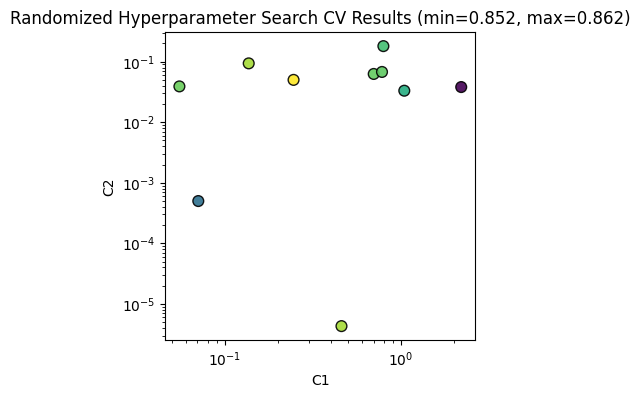

In [42]:
#https://stackoverflow.com/questions/61722752/attributeerror-randomizedsearchcv-object-has-no-attribute-grid-scores
_x = [s['c1'] for s in rs.cv_results_['params']]
_y = [s['c2'] for s in rs.cv_results_['params']]
_c = [s for s in rs.cv_results_['mean_test_score']]

fig = plt.figure()
fig.set_size_inches(4, 4)
ax = plt.gca()
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlabel('C1')
ax.set_ylabel('C2')
ax.set_title("Randomized Hyperparameter Search CV Results (min={:0.3}, max={:0.3})".format(
    min(_c), max(_c)
))

ax.scatter(_x, _y, c=_c, s=60, alpha=0.9, edgecolors=[0,0,0])

print("Dark blue => {:0.4}, dark red => {:0.4}".format(min(_c), max(_c)))

In [37]:
crf = rs.best_estimator_
y_pred = crf.predict(X_test)
print(metrics.flat_classification_report(
    y_test, y_pred, labels=sorted_labels, digits=3
))

/usr/local/lib/python3.9/dist-packages/sklearn/utils/validation.py:67: FutureWarning: Pass labels=['o', 'b-actor', 'i-actor', 'b-award', 'i-award', 'b-character', 'i-character', 'b-director', 'i-director', 'b-genre', 'i-genre', 'b-origin', 'i-origin', 'b-plot', 'i-plot', 'b-quote', 'i-quote', 'b-rating', 'i-rating', 'b-relationship', 'i-relationship', 'b-review', 'i-review', 'b-song', 'i-song', 'b-title', 'i-title', 'b-trailer', 'i-trailer', 'b-year', 'i-year'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                precision    recall  f1-score   support

             o      0.898     0.907     0.903     29657
       b-actor      0.923     0.926     0.925      2065
       i-actor      0.923     0.925     0.924      2417
       b-award      0.577     0.512     0.543        80
       i-award      0.638     0.651     0.645       195
   b-character      0.742     0.448     0.559       359
   i-character      0.706     0.509     0.592       269
    b-director      0.857     0.823     0.839       864
    i-director      0.872     0.844     0.858       880
       b-genre      0.875     0.882     0.878      1928
       i-genre      0.775     0.719     0.746       708
      b-origin      0.457     0.330     0.383       179
      i-origin      0.653     0.670     0.661       733
        b-plot      0.494     0.446     0.469      2027
        i-plot      0.855     0.912     0.883     14978
       b-quote      0.571     0.258     0.356        31
       i-quote      0.632     0.382     0.476  

/usr/local/lib/python3.9/dist-packages/sklearn/utils/validation.py:67: FutureWarning: Pass labels=['o', 'b-actor', 'i-actor', 'b-year', 'b-title', 'b-genre', 'i-genre', 'b-director', 'i-director', 'b-song', 'i-song', 'b-plot', 'i-plot', 'b-review', 'b-character', 'i-character', 'b-rating', 'i-review', 'i-title', 'i-rating', 'b-trailer', 'i-trailer', 'i-year', 'b-award', 'i-award', 'b-origin', 'i-origin', 'b-relationship', 'i-relationship', 'b-quote', 'i-quote'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Text(0.5, 1.0, 'CRF Model Performance Metrics')

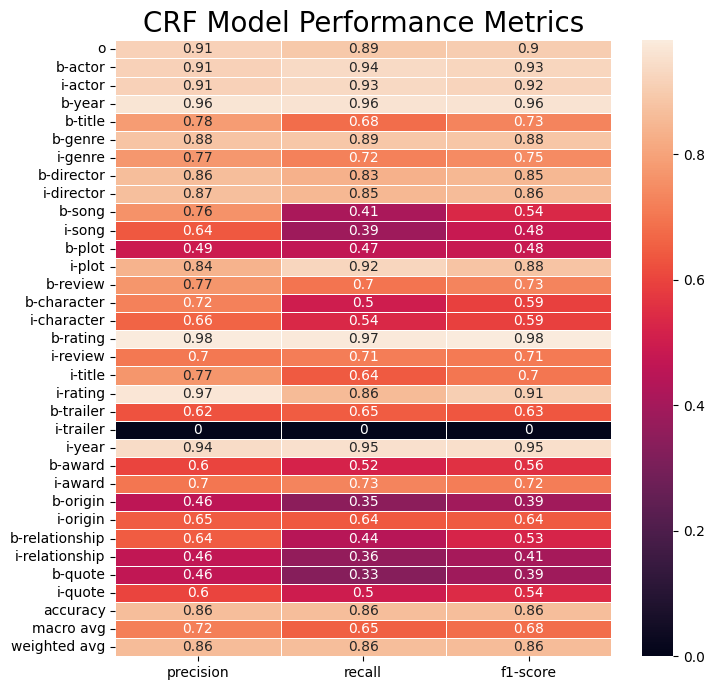

In [101]:
dict_class_report = dict(crf_metrics.flat_classification_report(y_test,y_pred, labels=labels, output_dict=True))

df_metrics = pd.DataFrame(dict_class_report).T
df_metrics.rename(index={'index': 'Tag'}, inplace=True)
df_metrics.head()

# https://stackoverflow.com/questions/28200786/how-to-plot-scikit-learn-classification-report
#https://stackoverflow.com/questions/38913965/make-the-size-of-a-heatmap-bigger-with-seaborn
fig, ax = plt.subplots(figsize=(8,8))         # Sample figsize in inches
sns.heatmap(df_metrics.iloc[:,:-1], annot=True, linewidths=.5, ax=ax)
plt.title('CRF Model Performance Metrics', fontsize=20)

In [39]:
def print_transitions(trans_features):
    for (label_from, label_to), weight in trans_features:
        print("%-6s -> %-7s %0.6f" % (label_from, label_to, weight))

print("Top likely transitions:")
print_transitions(Counter(crf.transition_features_).most_common(20))

print("\nTop unlikely transitions:")
print_transitions(Counter(crf.transition_features_).most_common()[-20:])

Top likely transitions:
b-origin -> i-origin 5.805905
i-relationship -> i-relationship 5.663076
b-title -> i-title 5.650106
i-origin -> i-origin 5.617469
i-plot -> i-plot  5.352587
b-director -> i-director 5.256020
i-award -> i-award 5.238756
b-actor -> i-actor 5.108300
b-relationship -> i-relationship 5.080039
i-quote -> i-quote 5.065673
i-title -> i-title 5.060117
b-song -> i-song  4.943980
i-year -> i-year  4.930204
i-song -> i-song  4.886099
b-plot -> i-plot  4.736401
b-rating -> i-rating 4.663010
b-quote -> i-quote 4.610814
b-award -> i-award 4.573058
i-review -> i-review 4.403321
b-review -> i-review 4.322107

Top unlikely transitions:
b-genre -> b-genre -4.717920
i-plot -> i-actor -4.826938
i-actor -> i-plot  -4.954495
i-plot -> i-character -4.960539
i-actor -> i-character -5.129219
o      -> i-award -5.449111
o      -> i-quote -5.513206
i-plot -> b-plot  -5.680111
o      -> i-rating -5.705578
o      -> i-director -5.754567
o      -> i-song  -5.881055
o      -> i-character -5.88

In [40]:
#https://towardsdatascience.com/named-entity-recognition-and-classification-with-scikit-learn-f05372f07ba2
eli5.show_weights(crf, top=5)

/usr/local/lib/python3.9/dist-packages/sklearn/base.py:209: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '


From \ To,o,b-actor,i-actor,b-award,i-award,b-character,i-character,b-director,i-director,b-genre,i-genre,b-origin,i-origin,b-plot,i-plot,b-quote,i-quote,b-rating,i-rating,b-relationship,i-relationship,b-review,i-review,b-song,i-song,b-title,i-title,b-trailer,i-trailer,b-year,i-year
o,1.978,1.22,-7.212,0.186,-5.449,0.761,-5.889,0.824,-5.755,0.607,-5.952,0.68,-6.165,0.89,-7.711,0.194,-5.513,0.459,-5.706,0.45,-5.899,0.915,-6.222,0.754,-5.881,0.88,-6.327,-0.263,-4.638,0.666,-6.486
b-actor,-0.962,-2.867,5.108,-0.439,-1.59,-2.205,-3.607,-1.39,-3.293,-2.634,-2.053,-1.427,-1.977,-0.65,-3.476,-1.586,-1.771,-1.376,-1.266,-1.563,-1.896,-0.994,-2.237,-1.355,-2.211,-2.446,-2.648,-1.091,-0.54,-1.131,-1.463
i-actor,0.764,-4.428,3.18,0.011,-2.511,-1.774,-5.129,-3.21,-3.267,0.788,-2.801,-0.151,-2.98,0.931,-4.954,-1.895,-2.631,-0.029,-1.916,-1.564,-2.185,0.55,-2.828,-1.07,-2.775,-2.482,-2.826,-0.553,-1.06,0.815,-3.168
b-award,-0.669,-1.237,-1.81,-0.009,4.573,-0.339,-0.369,-1.102,-1.174,-2.8,-1.023,-0.136,-0.961,-2.454,-1.972,-0.006,-0.062,-0.428,-0.132,-0.021,-0.309,-0.545,-0.542,-0.01,-0.057,-0.462,-0.923,-0.002,0.0,-0.021,-0.656
i-award,-0.014,-0.215,-1.784,-0.055,5.239,-0.427,-0.477,-0.001,-1.542,-0.141,-1.483,0.055,-1.313,-1.248,-2.585,-0.023,-0.057,-0.399,-0.072,0.118,-0.377,-0.053,-0.642,-0.006,-0.091,-0.684,-1.272,-0.005,0.0,-0.082,-0.793
b-character,-0.576,-2.295,-3.558,-0.355,-0.708,-1.396,3.264,-2.88,-3.898,-2.877,-2.312,-0.641,-2.991,1.34,-3.969,-0.356,-0.79,-1.426,-0.622,-0.488,-1.147,-1.698,-1.915,-0.388,-0.773,-1.673,-3.215,-0.42,-0.018,-1.798,-1.952
i-character,0.268,-0.327,-2.377,-0.227,-0.405,-0.747,3.37,-1.866,-1.955,-0.547,-1.413,-0.454,-2.032,1.783,-3.419,0.01,-0.496,-0.78,-0.406,-0.003,-0.692,-0.503,-1.194,-0.237,-0.442,-1.159,-2.22,-0.033,-0.002,-1.408,-1.061
b-director,-0.15,-2.582,-3.79,-0.841,-1.365,-1.526,-4.209,-2.996,5.256,-0.149,-2.586,-0.659,-2.151,-1.371,-3.172,-1.168,-2.045,-1.81,-1.426,0.002,-1.998,0.26,-2.048,-1.339,-1.932,0.014,-2.476,-0.631,-0.09,-0.172,-1.558
i-director,0.821,-1.566,-3.368,0.001,-1.743,-1.567,-3.238,-2.072,3.567,1.385,-2.881,-0.006,-2.728,-0.21,-3.362,-0.878,-1.952,-0.0,-1.456,0.116,-2.135,0.797,-2.659,-0.996,-1.621,-1.381,-2.528,-0.462,-0.048,0.641,-2.539
b-genre,0.595,-0.093,-3.784,-0.079,-2.107,-2.304,-4.513,0.251,-2.66,-4.718,3.97,0.574,-2.969,0.454,-3.774,-1.61,-2.097,0.136,-1.648,0.733,-2.543,1.034,-2.484,-2.729,-2.375,-1.916,-2.641,-1.088,-0.719,0.859,-2.194


## Implement CRF with Word2Vec in feature vector

### Create Word2Vec vectors

In [49]:
# convert the list of sentence lists of word tuples into just a list
# sentences words
l_sents = [[tup[0] for tup in l_sent] for l_sent in l_sentences[0:]]

In [50]:
print('sentence example 1:', l_sents[0])
print('sentence example 2:', l_sents[1])
print('number of sentences:', len(l_sents))
print ('number of unique words:' , len(set([word for sent in l_sents for word in sent ])))

sentence example 1: ['what', 'movies', 'star', 'bruce', 'willis']
sentence example 2: ['show', 'me', 'films', 'with', 'drew', 'barrymore', 'from', 'the', '1980s']
number of sentences: 21987
number of unique words: 15337


In [51]:
# define the parameters of word2vec model
feature_size = 12
window_context = 30
min_word_count = 1
sample = 1e-3

In [52]:
#instantiate the model
word2vec.Word2Vec()

In [53]:
# create the word2vec vectors
w2v_model = word2vec.Word2Vec(l_sents, 
                  vector_size= feature_size,
                  window = window_context,
                  min_count= min_word_count,
                  sample = sample,
                  )

In [54]:
# validate that words have vectors
w2v_model.wv['barrymore']

array([ 0.12754321, -0.08292866,  0.14068252, -0.21374537, -0.47547677,
        0.16536012,  0.02660271,  0.10729299, -0.08053581, -0.0570567 ,
        0.6661912 , -0.10735626], dtype=float32)

In [102]:
w2v_model.wv.similarity('death', 'star')

0.6597746

In [56]:
funcs.create_w2v_feature_dict(w2v_model, 'barrymore')

{'w2v_0': 0.12754321,
 'w2v_1': -0.082928665,
 'w2v_2': 0.14068252,
 'w2v_3': -0.21374537,
 'w2v_4': -0.47547677,
 'w2v_5': 0.16536012,
 'w2v_6': 0.026602708,
 'w2v_7': 0.10729299,
 'w2v_8': -0.08053581,
 'w2v_9': -0.057056703,
 'w2v_10': 0.6661912,
 'w2v_11': -0.10735626}

In [57]:
w2v_model.wv.most_similar('bruce')

[('li', 0.987670361995697),
 ('pitt', 0.9821360111236572),
 ('drew', 0.98158860206604),
 ('pairs', 0.9806956648826599),
 ('harold', 0.9804348945617676),
 ('timberlake', 0.9801297187805176),
 ('jr', 0.9781407117843628),
 ('barrymore', 0.9773724675178528),
 ('paul', 0.975517213344574),
 ('groucho', 0.9740949869155884)]

In [58]:
w2v_model.wv.get_normed_vectors()

array([[ 0.02431699,  0.16717122,  0.34842023, ...,  0.18868326,
         0.5556031 ,  0.22691771],
       [ 0.16209434,  0.01398762,  0.10147581, ..., -0.04698035,
         0.6555936 ,  0.0647158 ],
       [-0.3020174 , -0.14431171,  0.12920968, ..., -0.09458002,
         0.5628901 ,  0.17158863],
       ...,
       [ 0.31460077,  0.4828402 ,  0.0293694 , ..., -0.6020624 ,
        -0.19916561,  0.32198703],
       [-0.14535296,  0.3166426 ,  0.3635456 , ..., -0.24210815,
         0.2800125 , -0.15205805],
       [-0.31196663, -0.35753688, -0.07623837, ..., -0.20398405,
         0.33655718,  0.3143018 ]], dtype=float32)

# Word2Vec: Create features in the data include W2V Vector

In [59]:
#grouped_df is a series NOT a dataframe
#each entry in the series is a list
# the elements in the list are tuples, 
#        - first entry is a sentence word
#        - second entry is a POS tag
#        - third entry is a IOB tag
grouped_df1[1]

[('what', 'WP', 'o'),
 ('movies', 'NNS', 'o'),
 ('star', 'VBP', 'o'),
 ('bruce', 'NN', 'b-actor'),
 ('willis', 'NN', 'i-actor')]

In [60]:
# Standard tokenized sentence with POS and NER tags
# list of lists of tuples, where the list contains sentences reprsented as lists.
# Each sentence list contains a word in the sentence along with the POS and NER
l_sentences = [s for s in grouped_df1]
l_sentences[0]

[('what', 'WP', 'o'),
 ('movies', 'NNS', 'o'),
 ('star', 'VBP', 'o'),
 ('bruce', 'NN', 'b-actor'),
 ('willis', 'NN', 'i-actor')]

In [61]:
import importlib
importlib.reload(funcs)

<module 'crf_functions_w2v' from '/content/crf_functions_w2v.py'>

In [62]:
funcs.word2features_w2v(l_sentences[0], 0, w2v_model)

{'bias': 1.0,
 'word.lower()': 'what',
 'word[-3:]': 'hat',
 'word[-2:]': 'at',
 'word.isupper': False,
 'word.istitle()': False,
 'word.isdigit()': False,
 'postag': 'WP',
 'postag[:2]': 'WP',
 'w2v_0': 0.52182245,
 'w2v_1': 0.20700999,
 'w2v_2': -1.0107619,
 'w2v_3': -2.9033127,
 'w2v_4': -7.0036755,
 'w2v_5': -2.74958,
 'w2v_6': -2.1941364,
 'w2v_7': 1.7270828,
 'w2v_8': -0.17607072,
 'w2v_9': 0.3847476,
 'w2v_10': 0.96765774,
 'w2v_11': 1.5682436,
 'BOS': True,
 '+1:word.lower()': 'movies',
 '+1:word.istitle()': False,
 '+1:word.isupper': False,
 '+1:postag': 'NNS',
 '+1:postag[:2]': 'NN'}

In [63]:
# make the feature set
X = np.array([funcs.sent2features_w2v(s, w2v_model) for s in l_sentences], dtype=object)
# make the label set
y = np.array([funcs.sent2labels(s) for s in l_sentences], dtype=object)

In [64]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state= 42)
X_train.shape, X_test.shape

((16490,), (5497,))

# 4. Implement Model for Movie Data with word2vec

In [65]:
labels = list(df1.Tag.unique())

sorted_labels = sorted(
    labels,
    key=lambda name: (name[1:], name[0])
)

In [66]:
param_grid = {'c1': scipy.stats.expon(scale=0.5),
              'c2': scipy.stats.expon(scale=0.05),
}
param_grid

{'c1': <scipy.stats._distn_infrastructure.rv_continuous_frozen at 0x7f9741beaee0>,
 'c2': <scipy.stats._distn_infrastructure.rv_continuous_frozen at 0x7f9741ca85b0>}

In [67]:
# https://sklearn-crfsuite.readthedocs.io/en/latest/tutorial.html
# define the model
crf = sklearn_crfsuite.CRF(
    algorithm='lbfgs',
    max_iterations=50,
    all_possible_transitions=True
)

# define the scoring metric
f1_scorer = make_scorer(metrics.flat_f1_score,
                        average='weighted', labels=labels)

In [68]:
# create the randomized search
rs = RandomizedSearchCV(crf, param_grid,
                        cv=3,
                        verbose=1,
                        n_jobs=-1,
                        n_iter=10,
                        scoring=f1_scorer)

In [69]:
# search for the best regularization parameters
rs.fit(X_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


/usr/local/lib/python3.9/dist-packages/sklearn/base.py:209: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed: 34.4min finished


RandomizedSearchCV(cv=3,
                   estimator=CRF(algorithm='lbfgs',
                                 all_possible_transitions=True,
                                 keep_tempfiles=None, max_iterations=50),
                   n_jobs=-1,
                   param_distributions={'c1': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7f9741beaee0>,
                                        'c2': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7f9741ca85b0>},
                   scoring=make_scorer(flat_...=['o', 'b-actor', 'i-actor', 'b-year', 'b-title', 'b-genre', 'i-genre', 'b-director', 'i-director', 'b-song', 'i-song', 'b-plot', 'i-plot', 'b-review', 'b-character', 'i-character', 'b-rating', 'i-review', 'i-title', 'i-rating', 'b-trailer', 'i-trailer', 'i-year', 'b-award', 'i-award', 'b-origin', 'i-origin', 'b-relationship', 'i-relationship', 'b-quote', 'i-quote']),
                   verbose=1)

In [70]:
# crf = rs.best_estimator_
print('best params:', rs.best_params_)
print('best CV score:', rs.best_score_)
print('model size: {:0.2f}M'.format(rs.best_estimator_.size_ / 1000000))

best params: {'c1': 0.15358074625103163, 'c2': 0.015748232606746106}
best CV score: 0.862336482567316
model size: 3.75M


In [71]:
rs.cv_results_

{'mean_fit_time': array([121.00506123, 123.29026747, 122.67600036, 125.74371552,
        124.78330628, 127.88677184, 122.32836088, 127.41009378,
        125.56490501, 111.95396495]),
 'std_fit_time': array([ 4.71666717,  2.25465104,  3.93316553,  3.03100683,  3.1864752 ,
         0.69320122,  5.32873584,  1.50647847,  1.30563332, 10.20042239]),
 'mean_score_time': array([5.16596071, 4.84310818, 4.16187278, 4.36289986, 4.7696383 ,
        4.69347421, 4.90066179, 4.21284389, 3.92964196, 3.36879961]),
 'std_score_time': array([0.39792841, 1.33530436, 0.65691425, 0.33315834, 1.33054996,
        1.23007601, 0.35463851, 0.96578198, 0.99746919, 0.81399725]),
 'param_c1': masked_array(data=[0.6323635233993042, 0.06620068546370303,
                    1.6329615736190866, 0.9827368976394792,
                    1.4430760729268435, 0.6075385168410735,
                    0.08013852955932672, 0.13880742251771513,
                    1.1633952865456256, 0.15358074625103163],
              mask=[Fal

Dark blue => 0.8538, dark red => 0.8623


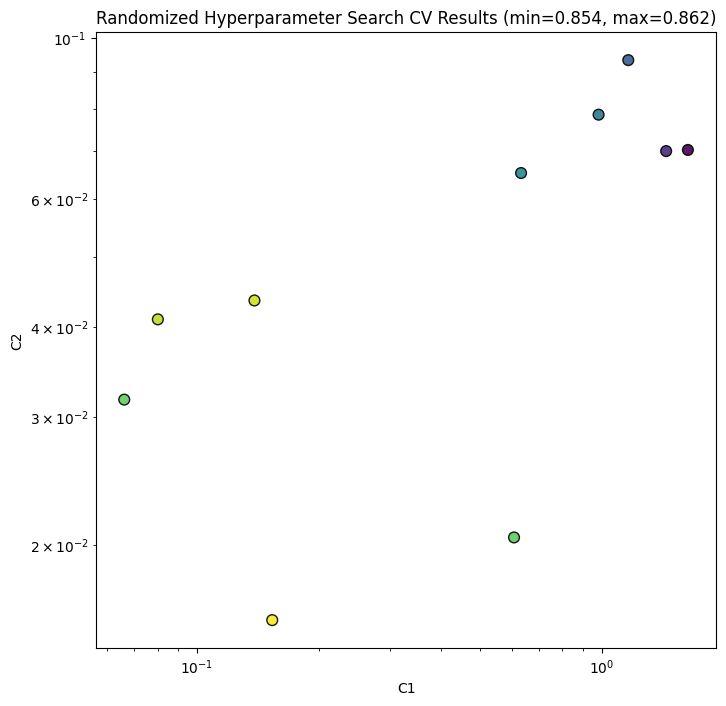

In [82]:
#https://stackoverflow.com/questions/61722752/attributeerror-randomizedsearchcv-object-has-no-attribute-grid-scores
_x = [s['c1'] for s in rs.cv_results_['params']]
_y = [s['c2'] for s in rs.cv_results_['params']]
_c = [s for s in rs.cv_results_['mean_test_score']]

fig = plt.figure()
fig.set_size_inches(8, 8)
ax = plt.gca()
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlabel('C1')
ax.set_ylabel('C2')
ax.set_title("Randomized Hyperparameter Search CV Results (min={:0.3}, max={:0.3})".format(
    min(_c), max(_c)
))

ax.scatter(_x, _y, c=_c, s=60, alpha=0.9, edgecolors=[0,0,0])

print("Dark blue => {:0.4}, dark red => {:0.4}".format(min(_c), max(_c)))

In [73]:
crf = rs.best_estimator_
y_pred = crf.predict(X_test)
print(metrics.flat_classification_report(
    y_test, y_pred, labels=sorted_labels, digits=3
))

/usr/local/lib/python3.9/dist-packages/sklearn/utils/validation.py:67: FutureWarning: Pass labels=['o', 'b-actor', 'i-actor', 'b-award', 'i-award', 'b-character', 'i-character', 'b-director', 'i-director', 'b-genre', 'i-genre', 'b-origin', 'i-origin', 'b-plot', 'i-plot', 'b-quote', 'i-quote', 'b-rating', 'i-rating', 'b-relationship', 'i-relationship', 'b-review', 'i-review', 'b-song', 'i-song', 'b-title', 'i-title', 'b-trailer', 'i-trailer', 'b-year', 'i-year'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                precision    recall  f1-score   support

             o      0.914     0.892     0.903     36962
       b-actor      0.915     0.936     0.925      2576
       i-actor      0.914     0.933     0.923      3010
       b-award      0.600     0.518     0.556       110
       i-award      0.701     0.730     0.716       267
   b-character      0.723     0.500     0.591       448
   i-character      0.663     0.536     0.593       345
    b-director      0.863     0.835     0.849      1076
    i-director      0.870     0.849     0.859      1096
       b-genre      0.881     0.888     0.885      2416
       i-genre      0.771     0.723     0.746       876
      b-origin      0.458     0.345     0.394       220
      i-origin      0.647     0.637     0.642       961
        b-plot      0.494     0.467     0.480      2565
        i-plot      0.837     0.925     0.878     19162
       b-quote      0.464     0.333     0.388        39
       i-quote      0.601     0.496     0.544  

/usr/local/lib/python3.9/dist-packages/sklearn/utils/validation.py:67: FutureWarning: Pass labels=['o', 'b-actor', 'i-actor', 'b-year', 'b-title', 'b-genre', 'i-genre', 'b-director', 'i-director', 'b-song', 'i-song', 'b-plot', 'i-plot', 'b-review', 'b-character', 'i-character', 'b-rating', 'i-review', 'i-title', 'i-rating', 'b-trailer', 'i-trailer', 'i-year', 'b-award', 'i-award', 'b-origin', 'i-origin', 'b-relationship', 'i-relationship', 'b-quote', 'i-quote'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Text(0.5, 1.0, 'CRF Model with Word2Vec Performance Metrics')

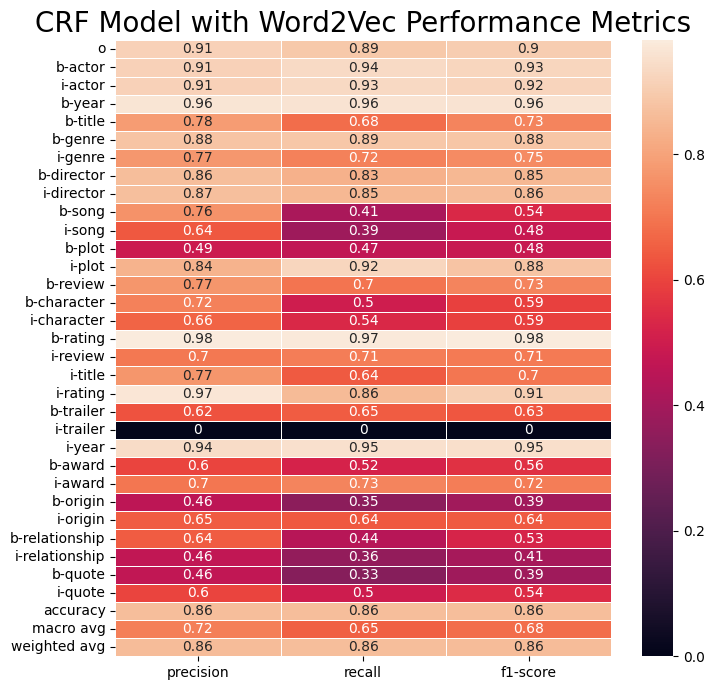

In [100]:
dict_class_report = dict(crf_metrics.flat_classification_report(y_test,y_pred, labels=labels, output_dict=True))

df_metrics = pd.DataFrame(dict_class_report).T
df_metrics.rename(index={'index': 'Tag'}, inplace=True)
df_metrics.head()

# https://stackoverflow.com/questions/28200786/how-to-plot-scikit-learn-classification-report
#https://stackoverflow.com/questions/38913965/make-the-size-of-a-heatmap-bigger-with-seaborn
fig, ax = plt.subplots(figsize=(8,8))         # Sample figsize in inches
sns.heatmap(df_metrics.iloc[:,:-1], annot=True, linewidths=.5, ax=ax)
plt.title('CRF Model with Word2Vec Performance Metrics', fontsize=20)

In [75]:
def print_transitions(trans_features):
    for (label_from, label_to), weight in trans_features:
        print("%-6s -> %-7s %0.6f" % (label_from, label_to, weight))

print("Top likely transitions:")
print_transitions(Counter(crf.transition_features_).most_common(20))

print("\nTop unlikely transitions:")
print_transitions(Counter(crf.transition_features_).most_common()[-20:])

Top likely transitions:
b-director -> i-director 6.057176
i-year -> i-year  5.349690
b-character -> i-character 5.291127
b-actor -> i-actor 5.254051
b-origin -> i-origin 5.231243
b-song -> i-song  5.203177
i-title -> i-title 5.009756
i-origin -> i-origin 4.999822
b-title -> i-title 4.970216
i-song -> i-song  4.906801
i-quote -> i-quote 4.879090
i-relationship -> i-relationship 4.706807
b-relationship -> i-relationship 4.613170
i-character -> i-character 4.554598
i-review -> i-review 4.514453
i-award -> i-award 4.417890
b-plot -> i-plot  4.344613
b-review -> i-review 4.340574
i-plot -> i-plot  4.222185
b-year -> i-year  3.959790

Top unlikely transitions:
i-genre -> b-genre -5.767303
i-plot -> i-quote -5.880920
i-actor -> i-plot  -6.035139
o      -> i-song  -6.109861
i-plot -> i-actor -6.129376
o      -> i-director -6.247924
o      -> i-character -6.438785
o      -> i-award -6.439663
b-genre -> b-genre -6.462875
o      -> i-quote -6.687825
o      -> i-origin -6.955932
o      -> i-title 

In [76]:
#https://towardsdatascience.com/named-entity-recognition-and-classification-with-scikit-learn-f05372f07ba2
eli5.show_weights(crf, top=5)

/usr/local/lib/python3.9/dist-packages/sklearn/base.py:209: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '


From \ To,o,b-actor,i-actor,b-award,i-award,b-character,i-character,b-director,i-director,b-genre,i-genre,b-origin,i-origin,b-plot,i-plot,b-quote,i-quote,b-rating,i-rating,b-relationship,i-relationship,b-review,i-review,b-song,i-song,b-title,i-title,b-trailer,i-trailer,b-year,i-year
o,1.423,0.853,-8.43,0.057,-6.44,0.623,-6.439,0.579,-6.248,0.252,-7.908,0.276,-6.956,0.512,-8.962,0.673,-6.688,0.197,-7.668,0.198,-7.236,0.918,-7.282,0.343,-6.11,1.783,-7.036,0.034,-5.108,0.681,-7.848
b-actor,-0.962,-3.266,5.254,-0.726,-2.326,-3.356,-3.156,-1.337,-3.439,-2.065,-2.389,-1.447,-2.182,-0.618,-4.397,-1.504,-2.354,-1.68,-1.65,-2.085,-2.312,-1.138,-2.468,-1.321,-1.959,-2.505,-3.19,-0.816,-0.043,-2.063,-1.519
i-actor,0.634,-4.837,3.411,0.033,-3.407,-1.953,-3.156,-3.301,-3.465,0.868,-3.819,-0.277,-3.24,0.928,-6.035,-1.644,-4.026,-0.146,-3.048,-1.843,-2.889,0.295,-3.952,-0.844,-2.613,-1.512,-3.443,-0.255,-1.85,1.042,-2.388
b-award,-1.27,-3.123,-2.271,-2.228,3.859,-1.497,-1.339,-3.387,-1.353,-3.489,-2.127,-1.374,-1.849,-3.13,-3.348,-0.323,-1.003,-1.563,-0.579,-0.846,-1.775,-2.036,-2.681,-0.673,-0.198,-1.088,-1.624,-0.016,-0.003,0.048,-0.6
i-award,-0.316,-0.65,-2.261,-3.397,4.418,-1.533,-1.026,-0.433,-1.114,-0.836,-1.958,0.0,-1.634,-3.394,-3.068,-0.404,-1.023,-0.209,-1.654,0.004,-1.696,-0.075,-2.583,0.039,-0.88,-1.056,-1.587,-0.198,-0.002,-0.892,-1.441
b-character,-0.135,-1.423,-2.918,-0.221,-1.613,-2.751,5.291,-2.163,-2.18,-3.269,-1.976,-1.649,-1.92,2.141,-4.322,-1.723,-2.535,-1.322,-1.482,-1.917,-2.045,-2.098,-1.824,-0.997,-1.528,-0.157,-2.614,0.0,-0.02,-1.979,-1.174
i-character,-0.032,-0.612,-2.725,-0.894,-1.665,-3.024,4.555,-2.051,-1.518,-0.739,-1.896,-1.009,-2.107,1.67,-4.75,0.452,-2.521,-1.676,-1.694,-0.021,-2.337,-2.107,-2.074,-0.988,-1.511,-1.967,-2.503,-0.181,-0.036,-2.205,-1.134
b-director,0.113,-2.901,-4.099,-0.589,-1.84,-1.067,-2.274,-3.176,6.057,0.044,-2.775,0.0,-2.386,-1.203,-3.571,-1.696,-1.847,-2.136,-1.837,0.623,-1.969,0.415,-2.209,-1.56,-1.678,0.25,-2.375,-0.215,-0.045,-0.133,-1.559
i-director,0.615,-2.045,-3.897,-0.001,-2.734,-1.379,-2.135,-2.341,3.921,1.264,-3.545,-0.002,-2.576,-0.196,-4.014,-1.951,-2.669,0.0,-2.07,0.269,-2.553,0.417,-2.781,-2.114,-1.76,-0.465,-2.495,-0.572,-0.078,1.082,-1.797
b-genre,0.544,-0.265,-4.173,0.11,-3.233,-1.752,-2.803,0.243,-2.574,-6.463,3.863,0.474,-3.546,0.474,-4.894,-2.013,-2.719,0.335,-2.336,0.415,-3.646,0.907,-3.38,-2.074,-2.541,-2.49,-3.155,-1.086,-0.686,0.596,-2.391


### Create Kmeans Word2Vec Clusters

In [77]:
# create a list of the word vectors
l_vectors = []
l_words = []
l_word_vector = []
i = 0
for word in w2v_model.wv.index_to_key:
    l_words.append(word)
    l_word_vector = w2v_model.wv[word]
    l_vectors.append(l_word_vector)
    i += 1
print('number of word vectors:', i)

number of word vectors: 15337


In [78]:
# calculate the silhouette score for each cluster number
l_num_clus = []
l_silhouette_scores = []

for num_clus in [10, 20, 50, 100, 250, 500, 1000]:
    print(num_clus)
    kmeans = KMeans(n_clusters= num_clus)
    kmeans.fit_predict(l_vectors)
    l_num_clus.append(num_clus)
    l_silhouette_scores.append(silhouette_score(l_vectors, kmeans.labels_))

10
20
50
100
250
500
1000


In [79]:
print('number of word labels:', len(kmeans.labels_))

number of word labels: 15337


In [80]:
print('number of cluster labels:', len(set(kmeans.labels_)))

number of cluster labels: 1000


Text(0.5, 1.0, 'Kmeans Clustering of Word2vec Feature Vectors')

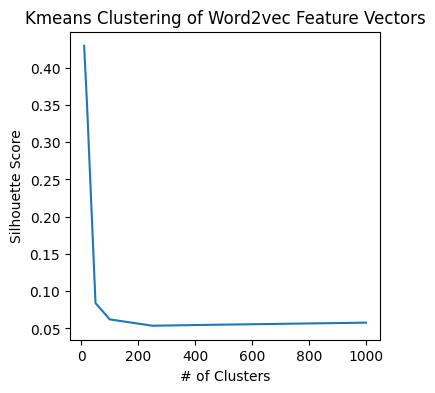

In [95]:
import matplotlib.pyplot as plt
fig = plt.figure()
fig.set_size_inches(4, 4)
plt.plot(l_num_clus,l_silhouette_scores)
plt.ylabel('Silhouette Score')
plt.xlabel('# of Clusters')
plt.title('Kmeans Clustering of Word2vec Feature Vectors')


In [106]:
# create a word to cluster dictionary

# create a list to hold the words in the word2vec object
l_word_to_cluster = []
l_word_cluster_number = []
l_word_vector

i = 0

for word in w2v_model.wv.index_to_key:
    l_word_to_cluster.append(word)
    l_word_vector = w2v_model.wv[word]
    l_word_cluster_number.append(kmeans.predict([l_word_vector])[0])
    i += 1

dict_word_cluster = dict(zip(l_word_to_cluster,l_word_cluster_number))
list(dict_word_cluster.items())[:5]

[('the', 88), ('a', 149), ('movie', 78), ('what', 55), ('in', 75)]

In [107]:
funcs.word2features_w2v_kmeans_clstr(l_sentences[0], 0, dict_word_cluster)

{'bias': 1.0,
 'word.lower()': 'what',
 'word[-3:]': 'hat',
 'word[-2:]': 'at',
 'word.isupper': False,
 'word.istitle()': False,
 'word.isdigit()': False,
 'postag': 'WP',
 'postag[:2]': 'WP',
 'kmeans_word2vec_clstr_num': 55,
 'BOS': True,
 '+1:word.lower()': 'movies',
 '+1:word.istitle()': False,
 '+1:word.isupper': False,
 '+1:postag': 'NNS',
 '+1:postag[:2]': 'NN'}

In [108]:
# make the feature set
X = np.array([funcs.sent2features_w2v_kmeans_clstr(s, dict_word_cluster) for s in l_sentences], dtype=object)
# make the label set
y = np.array([funcs.sent2labels(s) for s in l_sentences], dtype=object)

In [109]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state= 42)
X_train.shape, X_test.shape

((16490,), (5497,))

# 4. Implement Model for Movie Data with word2vec kmeans clusters

In [110]:
labels = list(df1.Tag.unique())

sorted_labels = sorted(
    labels,
    key=lambda name: (name[1:], name[0])
)

In [112]:
param_grid = {'c1': scipy.stats.expon(scale=0.5),
              'c2': scipy.stats.expon(scale=0.05),
}
param_grid

{'c1': <scipy.stats._distn_infrastructure.rv_continuous_frozen at 0x7f97446e5df0>,
 'c2': <scipy.stats._distn_infrastructure.rv_continuous_frozen at 0x7f9713f76e50>}

In [113]:
# https://sklearn-crfsuite.readthedocs.io/en/latest/tutorial.html
# define the model
crf = sklearn_crfsuite.CRF(
    algorithm='lbfgs',
    max_iterations=50,
    all_possible_transitions=True
)

# define the scoring metric
f1_scorer = make_scorer(metrics.flat_f1_score,
                        average='weighted', labels=labels)

In [114]:
# create the randomized search
rs = RandomizedSearchCV(crf, param_grid,
                        cv=3,
                        verbose=1,
                        n_jobs=-1,
                        n_iter=10,
                        scoring=f1_scorer)

In [115]:
# search for the best regularization parameters
rs.fit(X_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


/usr/local/lib/python3.9/dist-packages/sklearn/base.py:209: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed: 28.2min finished


RandomizedSearchCV(cv=3,
                   estimator=CRF(algorithm='lbfgs',
                                 all_possible_transitions=True,
                                 keep_tempfiles=None, max_iterations=50),
                   n_jobs=-1,
                   param_distributions={'c1': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7f97446e5df0>,
                                        'c2': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7f9713f76e50>},
                   scoring=make_scorer(flat_...=['o', 'b-actor', 'i-actor', 'b-year', 'b-title', 'b-genre', 'i-genre', 'b-director', 'i-director', 'b-song', 'i-song', 'b-plot', 'i-plot', 'b-review', 'b-character', 'i-character', 'b-rating', 'i-review', 'i-title', 'i-rating', 'b-trailer', 'i-trailer', 'i-year', 'b-award', 'i-award', 'b-origin', 'i-origin', 'b-relationship', 'i-relationship', 'b-quote', 'i-quote']),
                   verbose=1)

In [116]:
# crf = rs.best_estimator_
print('best params:', rs.best_params_)
print('best CV score:', rs.best_score_)
print('model size: {:0.2f}M'.format(rs.best_estimator_.size_ / 1000000))

best params: {'c1': 1.5524760203003165, 'c2': 0.00899177377273107}
best CV score: 0.610945038841458
model size: 2.19M


In [117]:
rs.cv_results_

{'mean_fit_time': array([107.87297098, 107.01576829, 107.37515378, 107.92822456,
        106.82962155, 109.98144317, 109.44731124, 107.26059985,
        106.41789365, 106.13773624]),
 'std_fit_time': array([2.22398754, 2.38919115, 2.28854773, 2.81850933, 2.59657003,
        1.67780714, 1.89754956, 2.10625437, 2.56296647, 4.02051907]),
 'mean_score_time': array([2.80544861, 2.60665989, 3.08936628, 3.23590883, 2.99522217,
        2.52830537, 2.52608554, 3.01429129, 2.9388442 , 2.1716284 ]),
 'std_score_time': array([0.27182743, 0.31748876, 0.39283854, 0.63949321, 0.75894237,
        0.01354431, 0.01851313, 0.50891151, 0.5988592 , 0.52606086]),
 'param_c1': masked_array(data=[0.22234512758766264, 0.07401516486921358,
                    1.0543326447852226, 0.3486116007811366,
                    0.46508548272679445, 1.5524760203003165,
                    1.5398302665850858, 0.7319279158617183,
                    0.4709882087034731, 0.44111947709460514],
              mask=[False, False,

Dark blue => 0.5604, dark red => 0.6109


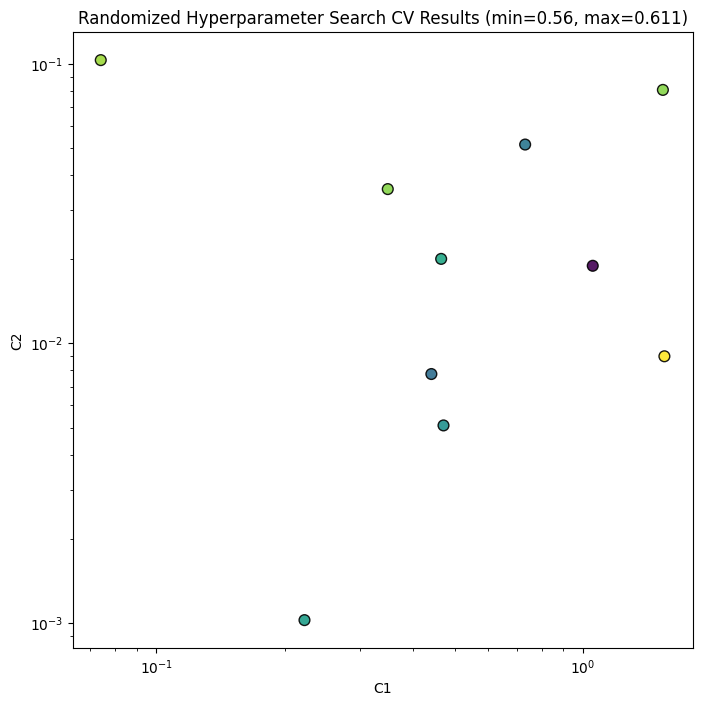

In [120]:
#https://stackoverflow.com/questions/61722752/attributeerror-randomizedsearchcv-object-has-no-attribute-grid-scores
_x = [s['c1'] for s in rs.cv_results_['params']]
_y = [s['c2'] for s in rs.cv_results_['params']]
_c = [s for s in rs.cv_results_['mean_test_score']]

fig = plt.figure()
fig.set_size_inches(8, 8)
ax = plt.gca()
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlabel('C1')
ax.set_ylabel('C2')
ax.set_title("Randomized Hyperparameter Search CV Results (min={:0.3}, max={:0.3})".format(
    min(_c), max(_c)
))

ax.scatter(_x, _y, c=_c, s=60, alpha=0.9, edgecolors=[0,0,0])

print("Dark blue => {:0.4}, dark red => {:0.4}".format(min(_c), max(_c)))

In [121]:
crf = rs.best_estimator_
y_pred = crf.predict(X_test)
print(metrics.flat_classification_report(
    y_test, y_pred, labels=sorted_labels, digits=3
))

/usr/local/lib/python3.9/dist-packages/sklearn/utils/validation.py:67: FutureWarning: Pass labels=['o', 'b-actor', 'i-actor', 'b-award', 'i-award', 'b-character', 'i-character', 'b-director', 'i-director', 'b-genre', 'i-genre', 'b-origin', 'i-origin', 'b-plot', 'i-plot', 'b-quote', 'i-quote', 'b-rating', 'i-rating', 'b-relationship', 'i-relationship', 'b-review', 'i-review', 'b-song', 'i-song', 'b-title', 'i-title', 'b-trailer', 'i-trailer', 'b-year', 'i-year'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                precision    recall  f1-score   support

             o      0.792     0.813     0.802     36962
       b-actor      0.581     0.612     0.596      2576
       i-actor      0.606     0.547     0.575      3010
       b-award      0.000     0.000     0.000       110
       i-award      0.000     0.000     0.000       267
   b-character      0.000     0.000     0.000       448
   i-character      0.000     0.000     0.000       345
    b-director      0.269     0.146     0.189      1076
    i-director      0.382     0.138     0.203      1096
       b-genre      0.529     0.397     0.454      2416
       i-genre      0.299     0.242     0.268       876
      b-origin      0.000     0.000     0.000       220
      i-origin      0.000     0.000     0.000       961
        b-plot      0.274     0.285     0.279      2565
        i-plot      0.623     0.915     0.741     19162
       b-quote      0.000     0.000     0.000        39
       i-quote      0.000     0.000     0.000  

/usr/local/lib/python3.9/dist-packages/sklearn/utils/validation.py:67: FutureWarning: Pass labels=['o', 'b-actor', 'i-actor', 'b-year', 'b-title', 'b-genre', 'i-genre', 'b-director', 'i-director', 'b-song', 'i-song', 'b-plot', 'i-plot', 'b-review', 'b-character', 'i-character', 'b-rating', 'i-review', 'i-title', 'i-rating', 'b-trailer', 'i-trailer', 'i-year', 'b-award', 'i-award', 'b-origin', 'i-origin', 'b-relationship', 'i-relationship', 'b-quote', 'i-quote'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


Text(0.5, 1.0, 'CRF Model with Word2Vec Clusters \n Performance Metrics')

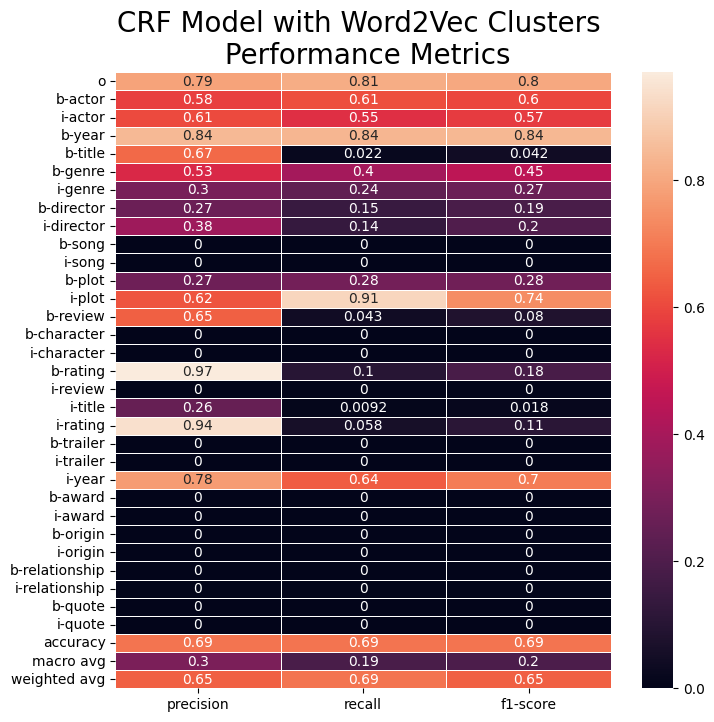

In [122]:
dict_class_report = dict(crf_metrics.flat_classification_report(y_test,y_pred, labels=labels, output_dict=True))

df_metrics = pd.DataFrame(dict_class_report).T
df_metrics.rename(index={'index': 'Tag'}, inplace=True)
df_metrics.head()

# https://stackoverflow.com/questions/28200786/how-to-plot-scikit-learn-classification-report
#https://stackoverflow.com/questions/38913965/make-the-size-of-a-heatmap-bigger-with-seaborn
fig, ax = plt.subplots(figsize=(8,8))         # Sample figsize in inches
sns.heatmap(df_metrics.iloc[:,:-1], annot=True, linewidths=.5, ax=ax)
plt.title('CRF Model with Word2Vec Clusters \n Performance Metrics', fontsize=20)

In [123]:
def print_transitions(trans_features):
    for (label_from, label_to), weight in trans_features:
        print("%-6s -> %-7s %0.6f" % (label_from, label_to, weight))

print("Top likely transitions:")
print_transitions(Counter(crf.transition_features_).most_common(20))

print("\nTop unlikely transitions:")
print_transitions(Counter(crf.transition_features_).most_common()[-20:])

Top likely transitions:
i-plot -> i-plot  4.090235
b-plot -> i-plot  3.829161
b-actor -> i-actor 3.603779
b-director -> i-director 2.107858
i-origin -> i-origin 1.783839
b-genre -> i-genre 1.582624
o      -> b-actor 1.524627
o      -> b-director 1.402163
o      -> o       1.334720
o      -> b-review 1.281359
b-year -> i-year  1.169263
b-title -> i-title 1.117839
o      -> b-genre 1.064914
i-title -> i-title 1.036064
o      -> b-plot  1.026086
b-review -> i-review 1.011810
i-actor -> o       0.991599
i-genre -> o       0.958158
o      -> b-title 0.949446
o      -> b-year  0.907867

Top unlikely transitions:
o      -> i-director -0.776681
i-plot -> i-title -0.830266
i-plot -> b-director -0.840422
i-plot -> i-director -0.925432
i-title -> i-plot  -0.928515
b-director -> i-plot  -0.942560
i-plot -> b-year  -0.996020
i-plot -> o       -1.019398
i-director -> i-plot  -1.028258
i-plot -> b-genre -1.047601
b-year -> i-plot  -1.104368
i-plot -> b-actor -1.106498
b-genre -> i-plot  -1.139543
i-p

In [ ]:
#https://towardsdatascience.com/named-entity-recognition-and-classification-with-scikit-learn-f05372f07ba2
eli5.show_weights(crf, top=5)

/usr/local/lib/python3.9/dist-packages/sklearn/base.py:209: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '


From \ To,o,b-actor,i-actor,b-award,i-award,b-character,i-character,b-director,i-director,b-genre,i-genre,b-origin,i-origin,b-plot,i-plot,b-quote,i-quote,b-rating,i-rating,b-relationship,i-relationship,b-review,i-review,b-song,i-song,b-title,i-title,b-trailer,i-trailer,b-year,i-year
o,1.839,1.451,-2.385,0.001,-0.416,0.448,-0.681,0.639,-1.18,1.06,-0.76,0.237,-0.842,1.162,-6.901,-0.0,-0.537,1.433,-0.375,0.007,-0.549,1.292,-0.693,0.0,-0.444,0.169,-1.077,-0.0,-0.347,1.082,-0.737
b-actor,-2.085,-0.833,3.389,-0.149,-0.168,-0.302,-0.279,-0.458,-0.482,-0.614,-0.312,-0.187,-0.345,-0.465,-2.575,-0.142,-0.22,-0.185,-0.15,-0.212,-0.225,-0.322,-0.285,-0.153,-0.18,-0.388,-0.441,-0.142,-0.036,-0.529,-0.302
i-actor,1.172,-0.934,0.007,-0.022,-0.19,-0.339,-0.315,-0.518,-0.544,-0.078,-0.352,-0.204,-0.389,0.017,-2.952,-0.16,-0.248,-0.204,-0.17,-0.238,-0.254,-0.078,-0.321,-0.172,-0.204,-0.436,-0.498,-0.158,-0.056,-0.19,-0.341
b-award,-0.124,-0.16,-0.183,-0.001,0.206,-0.073,-0.05,-0.096,-0.099,-0.121,-0.075,-0.041,-0.079,-0.128,-0.508,-0.007,-0.044,-0.041,-0.038,-0.018,-0.044,-0.076,-0.07,-0.007,-0.04,-0.084,-0.092,-0.001,0.0,-0.052,-0.073
i-award,-0.002,-0.127,-0.206,-0.009,0.387,-0.08,-0.076,-0.012,-0.111,-0.094,-0.083,-0.001,-0.088,-0.145,-0.568,-0.001,-0.047,-0.043,-0.039,-0.002,-0.048,-0.06,-0.077,-0.001,-0.043,-0.094,-0.104,-0.009,0.0,-0.085,-0.08
b-character,-0.571,-0.319,-0.365,-0.072,-0.08,-0.13,0.842,-0.187,-0.195,-0.242,-0.134,-0.087,-0.146,0.002,-0.986,-0.05,-0.099,-0.086,-0.072,-0.096,-0.101,-0.138,-0.124,-0.073,-0.084,-0.161,-0.18,-0.05,-0.003,-0.212,-0.13
i-character,-0.002,-0.295,-0.338,-0.049,-0.076,-0.122,0.173,-0.174,-0.181,-0.223,-0.125,-0.082,-0.137,0.001,-0.915,-0.001,-0.094,-0.082,-0.05,-0.064,-0.095,-0.129,-0.116,-0.07,-0.08,-0.151,-0.168,-0.047,-0.001,-0.197,-0.122
b-director,-1.018,-0.477,-0.543,-0.093,-0.105,-0.182,-0.17,-0.273,3.277,-0.224,-0.189,-0.082,-0.208,-0.379,-1.465,-0.064,-0.135,-0.115,-0.094,-0.091,-0.138,-0.129,-0.173,-0.095,-0.112,-0.155,-0.262,-0.064,-0.006,-0.311,-0.183
i-director,0.593,-0.495,-0.568,-0.006,-0.108,-0.189,-0.177,-0.283,0.0,0.002,-0.196,-0.019,-0.216,-0.119,-1.531,-0.066,-0.14,-0.08,-0.096,-0.021,-0.143,-0.008,-0.18,-0.098,-0.115,-0.241,-0.274,-0.065,-0.006,-0.074,-0.19
b-genre,1.275,-0.441,-0.713,-0.082,-0.131,-0.232,-0.216,-0.221,-0.37,-0.471,2.448,-0.015,-0.266,-0.092,-1.931,-0.11,-0.17,-0.0,-0.117,-0.012,-0.174,-0.005,-0.22,-0.119,-0.14,-0.298,-0.338,-0.11,-0.028,-0.088,-0.233
